# Chapter 2: Multi-armed Bandits

## The 10-armed Testbed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

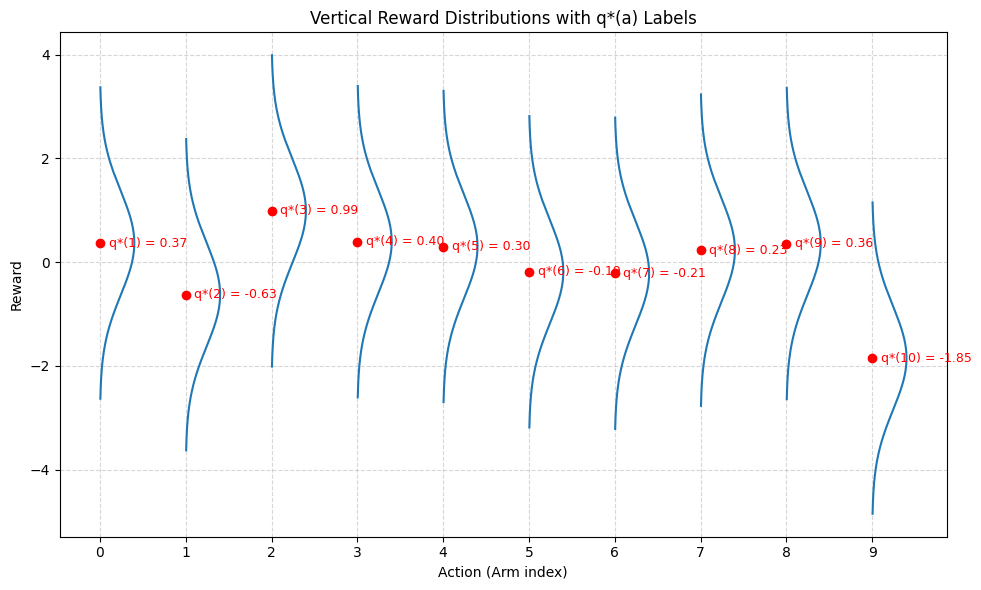

In [2]:
k = 10
true_action_values = np.random.normal(0,1,k)
x = np.linspace(-4,4,200)

plt.figure(figsize = (10,6))

for i,q in enumerate(true_action_values):
    y = np.linspace(q-3, q+3, 200)
    pdf = norm.pdf(y, loc = q, scale=1)
    pdf_scaled = pdf/pdf.max() * 0.4
    plt.plot(i+pdf_scaled, y, color = 'C0')

    #Red dot for mean
    plt.plot(i,q,'ro')
    #Label as q*(i+1)
    plt.text(i+0.1, q,  f'q*({i+1}) = {q:.2f}', color='red', fontsize=9, va='center')

# Plot details
plt.xlabel('Action (Arm index)')
plt.ylabel('Reward')
plt.title('Vertical Reward Distributions with q*(a) Labels')
plt.xticks(np.arange(k))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [3]:
class Bandit:
    def __init__(self, k=10):
        self.k = k
        self.q_true = np.random.normal(0,1,k)
        self.optimal_action = np.argmax(self.q_true)

    def pull(self, action):
        reward = np.random.normal(self.q_true[action],1)
        return reward

In [4]:
def epsilon_greedy_bandit(k=10, epsilon = 0.1, steps=1000):
    q_estimates = np.zeros(k)
    action_counts = np.zeros(k)
    rewards = np.zeros(steps)

    bandit = Bandit(k)

    for t in range(steps):

        if np.random.rand() < epsilon:
            action = np.random.randint(k) #Exploration
        else:
            action = np.argmax(q_estimates) #Exploit

        reward = bandit.pull(action)

        action_counts[action]+=1

        #sample average update rule
        q_estimates[action] += (1/action_counts[action])*(reward - q_estimates[action])

        rewards[t] = reward

    return rewards

In [5]:
def run_experiments(epsilons, episodes, steps):

    all_avg_rewards = np.zeros((len(epsilons), steps))

    for i, epsilon in enumerate(epsilons):
        for _ in range(episodes):
            rewards = epsilon_greedy_bandit(epsilon=epsilon, steps = steps)
            all_avg_rewards[i] += rewards
        all_avg_rewards[i] /= episodes

    return all_avg_rewards

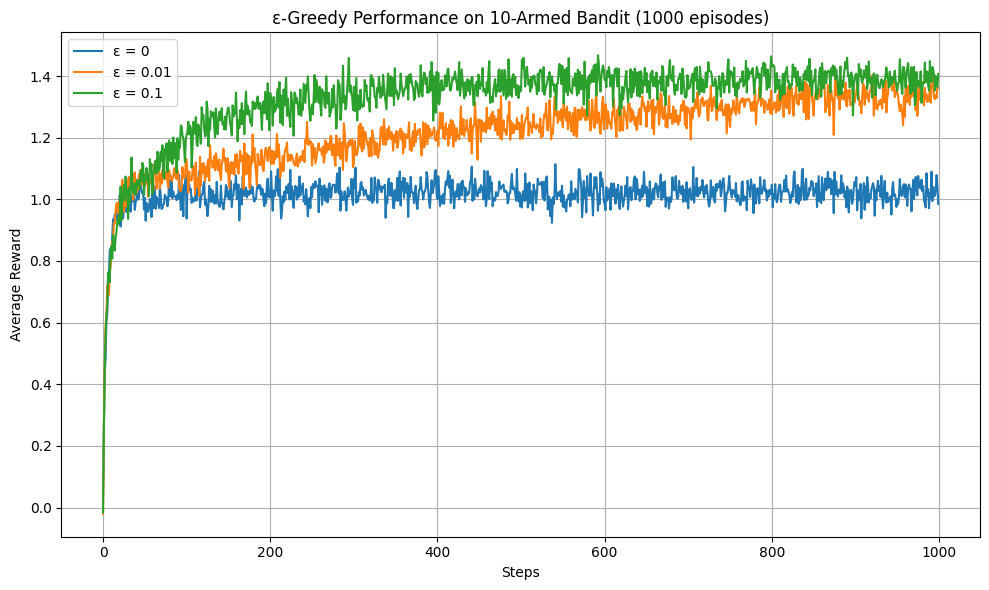

In [6]:
# Run for 1000 episodes per ε
epsilons = [0, 0.01, 0.1]
avg_rewards = run_experiments(epsilons, episodes=1000, steps=1000)

# Plotting
plt.figure(figsize=(10, 6))
for i, eps in enumerate(epsilons):
    plt.plot(avg_rewards[i], label=f"ε = {eps}")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("ε-Greedy Performance on 10-Armed Bandit (1000 episodes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Example 2.5: Simulate a non-stationary 10-armed testbed and show the challenges faced by sample-average (alpha = 1/n) method, and show how using a constant step size can overcome the problem.

In [7]:
class NonStationaryBandit:
    def __init__(self, k=10, walk_std=0.01):
        self.k = k
        self.walk_std = walk_std
        self.q_true = np.zeros(k)  # All true action values start at 0
        self.optimal_action = np.argmax(self.q_true)

    def step(self, action):
        # Reward is drawn from current q*(a) with std = 1
        reward = np.random.normal(self.q_true[action], 1)
        # Apply random walk to all true values
        self.q_true += np.random.normal(0, self.walk_std, self.k)
        # Update optimal action
        self.optimal_action = np.argmax(self.q_true)
        return reward

In [8]:
def run_agent(alpha=None, steps=1000, runs=2000, epsilon=0.1):
    k = 10
    rewards = np.zeros((runs, steps))

    for run in range(runs):
        bandit = NonStationaryBandit(k)
        Q = np.zeros(k)
        N = np.zeros(k)

        for t in range(steps):
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.argmax(Q)

            reward = bandit.step(action)

            N[action] += 1
            if alpha is None:
                # Sample-average method
                Q[action] += (1 / N[action]) * (reward - Q[action])
            else:
                # Constant step-size method
                Q[action] += alpha * (reward - Q[action])

            rewards[run, t] = reward


ValueError: x, y, and format string must not be None

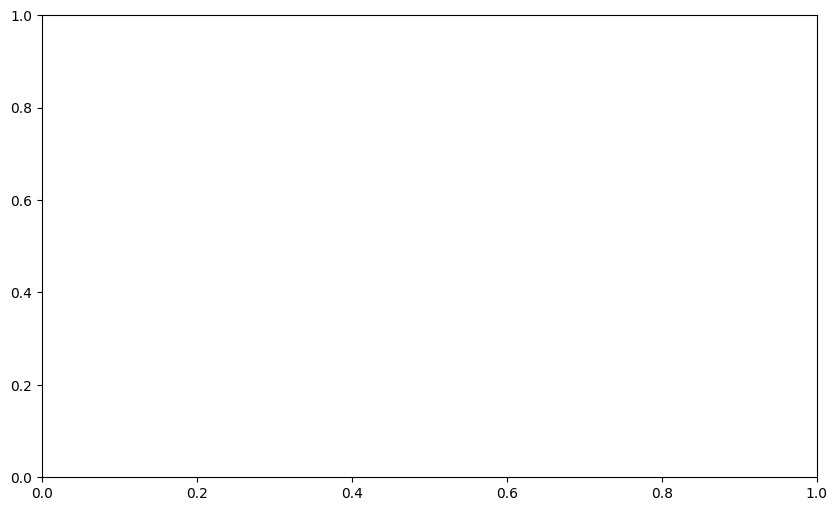

In [9]:
steps = 1000
sample_avg_rewards = run_agent(alpha=None, steps=steps)      # Sample average
const_step_rewards = run_agent(alpha=0.1, steps=steps)        # Constant alpha

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sample_avg_rewards, label='Sample Average (α = 1/n)')
plt.plot(const_step_rewards, label='Constant Step-Size (α = 0.1)')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Non-Stationary 10-Armed Bandit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()